<a href="https://colab.research.google.com/github/hspopal/tutorials/blob/main/neuroimaging/univariate_analyses/univariate_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univariate Analyses with Nilearn

This workshop will take users through a basic univariate first and second level analysis of fMRI data using the nilearn python package. A significant advantage of nilearn over other neuroimaging analysis tools is that it is python based, and built in a way that mimics well-established python packages like scikit-learn. Therefore, if you learn nilearn, you're also learning python and packages that are useful outside of the neuroimaging field. And likewise, if you are not well-versed in fMRI analyses, but you are skilled in python, you should be able to dive in with the mode looking and functioning similarly to code you might already be used to.

## Setup

### Install [nilearn](https://nilearn.github.io/stable/quickstart.html)

In [ ]:
!pip install nilearn

### Import packages

In [ ]:
# Basic
import glob
import os
import sys

# Data management
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Nilearn functions
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_glass_brain

### Using openneuro BIDS data
For this workshop, we will use an online repository of a BIDS dataset. The code below will download the data to a temporary directory on the Google servers. It will not be downloaded locally or to your Google Drive.

Takes about 10 minutes to complete.

In [ ]:
from nilearn.datasets import (
    fetch_ds000030_urls,
    fetch_openneuro_dataset,
    select_from_index,
)

_, urls = fetch_ds000030_urls()

exclusion_patterns = [
    "*group*",
    "*phenotype*",
    "*mriqc*",
    "*parameter_plots*",
    "*physio_plots*",
    "*space-fsaverage*",
    "*space-T1w*",
    "*dwi*",
    "*beh*",
    "*task-bart*",
    "*task-rest*",
    "*task-scap*",
    "*task-task*",
]
urls = select_from_index(
    urls, exclusion_filters=exclusion_patterns, n_subjects=4
)

bids_dir, _ = fetch_openneuro_dataset(urls=urls, verbose=0)

os.chdir(bids_dir)
print(bids_dir)


/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed


Above, we have defined the BIDS directory. I like to do this in the beginning of a script, just so it is easier to define paths later on. If ou are using your own dataset, you can set the bids_dir variable to the path of your BIDS directory.

### Import subject data
First, we can examine what participants are in this dataset. This would be useful to know in case we want to do any group analyses, or to correlate any behavioral measures with the brain data.

Cool note: Google Colab provides us with some plotting recommendations to visualize the data.

In [ ]:
subjs_list = pd.read_csv(bids_dir+'/participants.tsv', sep='\t')

subjs_list.head()

,participant_id,diagnosis,age,gender,bart,bht,dwi,pamenc,pamret,rest,scap,stopsignal,T1w,taskswitch,ScannerSerialNumber
0,sub-10159,CONTROL,30,F,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0
1,sub-10171,CONTROL,24,M,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0
2,sub-10189,CONTROL,49,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0
3,sub-10193,CONTROL,40,M,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,35343.0
4,sub-10206,CONTROL,21,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0


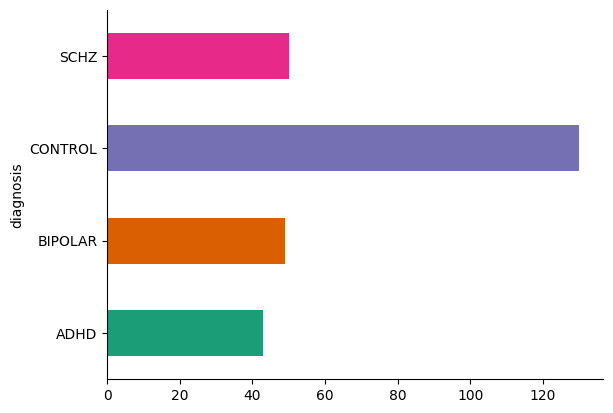

In [ ]:
# @title diagnosis

from matplotlib import pyplot as plt
import seaborn as sns
subjs_list.groupby('diagnosis').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)



---


# Single Subject Analysis

## Define study and subject variables
Below we will define some variables just to make our coding easier later. We do this using some basic python code. When we define the examine subject, we can use pandas functions to reference the first value in the 'participant_id' column of the subjs_list dataframe we defined above.

In [ ]:
# Define which task we want to analyze
task = 'stopsignal'

# Set subj to the first subject in the dataframe
subj = subjs_list.loc[0,'participant_id']

# Define fmriprep template space
template = 'MNI152NLin2009cAsym'

# Define the TR of the functional task
tr = 2

One of the advantages of using nilearn is that we can do some easy data management with python, all in the same script or notebook. Below, we are going to set up the directories for our analyses. In this case, we are going to output the univariate analyses into the derivatives directory, and then create subdirectories for the "stopsignal" task and for our example subject.

In [ ]:
# Set output directory path
outp_dir = os.path.join(bids_dir, 'derivatives', task, subj)
print(outp_dir)

# Make participant-specific directory for output if it doesn't exist
if not os.path.exists(outp_dir):
    os.makedirs(outp_dir)

/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/stopsignal/sub-10159


## Find Imaging Data

In [ ]:
# Set path to subject specific fmriprep output
fmri_run_data_dir = bids_dir+'/derivatives/fmriprep/'+subj+'/func/'


### Find functional runs
First, let's find the preprocessed data for our example subject, for the stopsignal task. We can do this using wildcards, just like in bash.

In [ ]:
# Find all of the preprocessed functional runs
func_runs = [f for f in glob.glob(fmri_run_data_dir+subj+'_task-'+task+'*space-'+template+'_desc-preproc_bold.nii.gz', recursive=True)]
func_runs.sort()
print('Number of functional runs for '+subj+': '+str(len(func_runs)))

Number of functional runs for sub-10159: 1


### Set a brain mask

Note: we are not going to be using this because it is too memory intensive for colab.

In [ ]:
# Grab subject's T1 as a mask to keep analysis in subject space
subj_mask = bids_dir+'derivatives/fmriprep/'+subj+'/anat/'+subj+'_space-'+template+'_brainmask.nii.gz'

## Create Design Matrix
The first level design matrix is a critical part of the whole analysis pipeline. With the design matrix, we can specify the variables we want to look at, and how those variables are treated. For example, we can examine regressors from the functional task, while accounting for motion and other nuissance variables. When doing multivariate analyses, it is suggested that each regressor of interest be modeled separately between runs. There are a lot of different ways to set up your design matrix. With nilearn, design matrices are just dataframes. So if you are familiar with pandas, you should be able to create design matrices be combining data from your task output, the nuissance regressors outputted from fmriprep, and create specific regressors based on your analysis needs.


Since we are doing a straight forward univariate analysis, we are going to use nilearn's built in functions to create the design matrix automatically when doing the GLM. Then we can examine the design matrix to make sure it is appropriate and make any changes we like.

### Import the events file

In [ ]:
# Find the task event files that are ready to become design matrices
event_files = [f for f in glob.glob(bids_dir+'/'+subj+'/func/'+subj+'_task-'+task+'*_events'+'.tsv', recursive=True)]
event_files.sort()

events = pd.read_csv(event_files[0], sep='\t')
events.fillna('', inplace=True)

events.head()

,onset,duration,trial_type,PresentedStimulusArrowDirection,ReactionTime,SubjectResponseButton,SubjectResponseButtonCode,SubjectResponseCorrectness,TrialOutcome,StopSignalDelay,LadderNumber,LadderTime,LadderMovement,TimeCourse,onset_noTriggerAdjust,TimeCourse_noTriggerAdjust
0,0.006134,1.50,GO,LEFT,0.416274,LEFT,5,CorrectResponse,SuccessfulGo,0.0,0,0,0,0.00,0.006134,0.00
1,0.000000,2.25,,BLANKSCREEN,0.000000,,0,,,0.0,0,0,0,1.50,0.000000,1.50
2,3.762595,1.50,GO,RIGHT,0.395370,RIGHT,28,CorrectResponse,SuccessfulGo,0.0,0,0,0,3.75,3.762595,3.75
3,0.000000,0.75,,BLANKSCREEN,0.000000,,0,,,0.0,0,0,0,5.25,0.000000,5.25
4,6.013056,1.50,GO,LEFT,0.397906,LEFT,5,CorrectResponse,SuccessfulGo,0.0,0,0,0,6.00,6.013056,6.00


### Import motion regressors

In [ ]:
confounds = pd.read_csv(fmri_run_data_dir+subj+'_task-'+task+'_desc-confounds_regressors.tsv', sep='\t')

# Replace NaN values with means for the respective variable
confounds.fillna(confounds.mean(), inplace=True)

confounds.head()

,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,tCompCor03,...,aCompCor02,aCompCor03,aCompCor04,aCompCor05,X,Y,Z,RotX,RotY,RotZ
0,-0.899719,2.227516,1.048748,23.691290,0.978043,0.164863,-0.118771,0.113172,-0.032137,0.041810,...,-0.140582,0.018290,-0.106118,0.188625,0.143525,-0.052645,-0.274967,0.001024,0.001434,0.000467
1,-1.246341,0.326954,1.090498,24.634428,1.026863,0.099904,-0.181387,0.036984,0.113388,0.048676,...,0.070998,0.058030,-0.015722,0.111118,0.163622,-0.028109,-0.263217,0.000837,0.002068,0.000516
2,0.366020,-1.068786,1.151430,26.010887,1.027507,0.252018,-0.046286,-0.033369,-0.076722,0.032938,...,-0.031604,-0.052342,-0.031574,-0.061752,0.118415,-0.006555,-0.167094,0.001868,0.001368,0.000464
3,-0.564770,-1.443347,1.106344,24.992373,0.920317,0.122212,-0.043669,-0.053250,-0.036809,-0.024905,...,-0.011359,0.010522,-0.061436,0.018885,0.096408,-0.006393,-0.137269,0.000894,0.000948,0.000454
4,-1.436600,-3.153236,0.914109,20.649788,0.871629,0.014257,-0.074981,-0.079292,0.079099,-0.054966,...,0.079117,0.063985,-0.049137,0.070348,0.102231,-0.006412,-0.136650,0.001024,0.000948,0.000429


## First level analysis for a single subject

### Set the first level model parameters

In [ ]:
fmri_glm = FirstLevelModel(t_r=tr,
                            #mask_img=subj_mask,  # Too memory intensive for colab
                            #slice_time_ref=0.5,  # Check to see how your data was preprocessed
                            noise_model='ar1',
                            standardize=False,
                            hrf_model='spm',
                            drift_model='polynomial')

### Conduct the GLM using the functional data, event file, and the confounds

One of the greatest advantages of nilearn is that it is built like other well-established python packages. For example, in specifying the first level model and completing that analysis, we define the model object, then "fit" the data to it, just like how models are defined and used in [scikit-learn](https://scikit-learn.org/stable/), a very popular machine learning package for python.

**Exercise:** Conduct the first level GLM using the [fit function](https://nilearn.github.io/stable/modules/generated/nilearn.glm.first_level.FirstLevelModel.html#nilearn.glm.first_level.FirstLevelModel.fit) of the FirstLevelModel object.

In [ ]:
# Conduct the GLM using the functional data, event file, and the confounds
fmri_glm = fmri_glm.fit(..., ..., ...)
fmri_glm

In [ ]:
# @title Click for solution
fmri_glm = fmri_glm.fit(func_runs, events, confounds)
fmri_glm

/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: StopSignalDelay, SubjectResponseCorrectness, LadderTime, PresentedStimulusArrowDirection, SubjectResponseButtonCode, TrialOutcome, ReactionTime, onset_noTriggerAdjust, TimeCourse, TimeCourse_noTriggerAdjust, LadderMovement, LadderNumber, SubjectResponseButton
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


FirstLevelModel(drift_model='polynomial', hrf_model='spm', t_r=2)

### Examine the design matrix
The first level model fitting creates a design matrix using the events and confounds files. We can pull the design matric from the GLM object we created.

In [ ]:
# Specify the design matrix to pull conditions and contrasts later
design_matrix = fmri_glm.design_matrices_[0]

**Exercise:** Plot a heatmap of the design matrix

Again, nilearn acts like other python packages. Here, the design matrix is just a pandas dataframe. Once we have pulled it, we can plot it using common python packages, like the seaborn package.

In [ ]:
sns.heatmap(..., vmin=-1, vmax=1, cmap='Greys')

<Axes: >

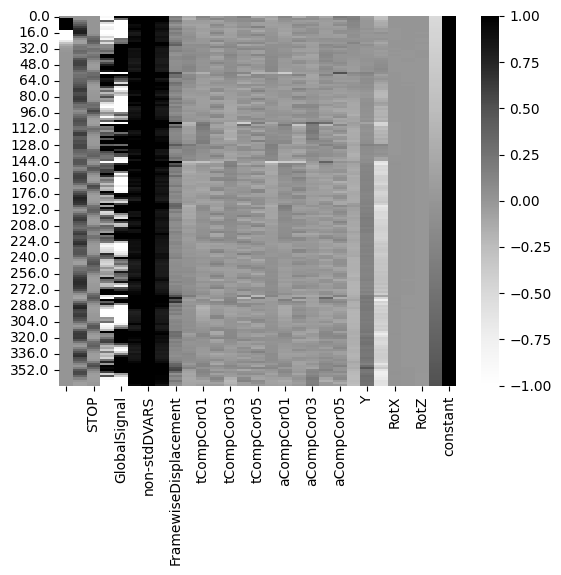

In [ ]:
# @title Click for solution

sns.heatmap(design_matrix, vmin=-1, vmax=1, cmap='Greys')

Alternatively, the GLM fit command can receive a pre-made design matrix as an input instead of the events and confound files. Design matrices can be made using the [make_first_level_design_matrix](https://nilearn.github.io/stable/modules/generated/nilearn.glm.first_level.make_first_level_design_matrix.html#nilearn.glm.first_level.make_first_level_design_matrix) command. The GLM fit command actually runs this in the back ground. This might be useful if you want to create regressors that wouldn't be already included in the events file, such as computational modeling parameters (like a reward prediction error parameter).

### Contrasts
If we print out the columns of the design matrix, we can easily see which regressors we want to use to create contrasts.

In [ ]:
design_matrix.columns

Index(['', 'GO', 'STOP', 'WhiteMatter', 'GlobalSignal', 'stdDVARS',
       'non-stdDVARS', 'vx-wisestdDVARS', 'FramewiseDisplacement',
       'tCompCor00', 'tCompCor01', 'tCompCor02', 'tCompCor03', 'tCompCor04',
       'tCompCor05', 'aCompCor00', 'aCompCor01', 'aCompCor02', 'aCompCor03',
       'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ',
       'drift_1', 'constant'],
      dtype='object')

The two main regressors of interests in the stopsignal task are the "GO" and "STOP" conditions. We will pull these two conditions and make a beta map for each. The code below takes our relevant conditions and finds the index of these conditions within the dataframe columns. Then it creates an array which specifies the index of the given condition, and zeros for everything else. That way we can pull the brain response for that signal condition and nothing else.

<Axes: >

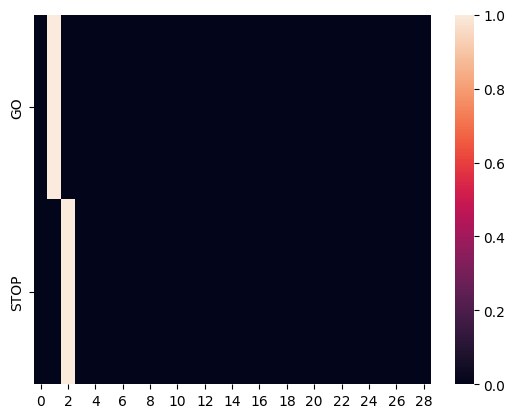

In [ ]:
relv_conds=['GO', 'STOP']

# Find the total number of conditions in the design matrix
n_conds = len(design_matrix.columns)

contrasts = {}
# Loop through the relevant conditions
for cond in relv_conds:
    # Create an empty array of zeros
    contrasts[cond] = np.zeros(n_conds)

    # Find the index of the condition of interest
    cond_idx = [design_matrix.columns.to_list().index(cond)]

    # Set that index to 1
    contrasts[cond][cond_idx] = 1

sns.heatmap(pd.DataFrame(contrasts).T)

In [ ]:
contrasts

{'GO': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'STOP': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [ ]:
# Create z-scored beta maps contrasts
for n_cont in range(len(contrasts)):
    cont_name = list(contrasts.keys())[n_cont]
    z_map = fmri_glm.compute_contrast(contrasts[cont_name], output_type='z_score')

    z_map.to_filename(os.path.join(outp_dir,'zmap_'+task+'_'+cont_name+'.nii.gz'))


After using the "compute_contrast" command, we can get a beta map for a given contrast. Then, we can plot the beta map for a singal participant. This is helpful to examine whether anything has gone horribly wrong. In my field of social cognition, these maps often look like complete randomness, which tells me everything is good.

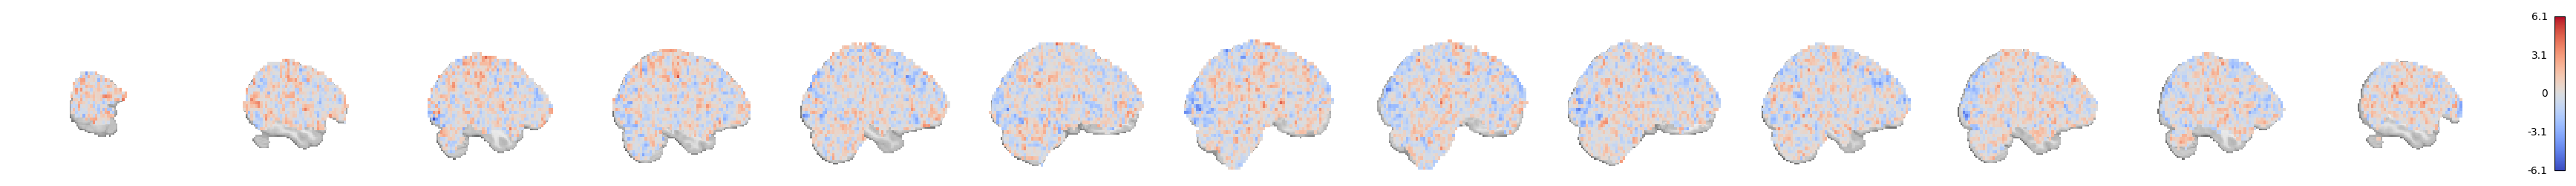

In [ ]:
plot_stat_map(z_map,
              cut_coords=range(-65,65, 10), display_mode='x', colorbar=True,
              cmap='coolwarm', symmetric_cbar=True, annotate=False)

## Create Specific Contrasts
Often, we want to examine a specific contrast from a task, where conditions are compared against each other. In the case of the stopsignal task, we can to see the neural response to the GO condition versus the STOP condition. The code below can be used to specify which conditions we want to test against each other.

In [ ]:
# Create a list of conditions that will be tested against each other
# The index of each list will be the contrast (e.g. cond_a_list[0] > cond_b_list[0])
cond_a_list = ['STOP']
cond_b_list = ['GO']
contrasts_df = pd.DataFrame(list(zip(cond_a_list, cond_b_list)),
                            columns=['cond_a','cond_b'])
contrasts_df

,cond_a,cond_b
0,STOP,GO


In [ ]:
# Create a dictionary that will store the contrast arrays
contrasts_bw_conds = {}

dm_cols = list(design_matrix.columns)

Like before, we will loop through our contrasts of interest and specify 1 for our first condition in the contrast, and -1 for the second condition of interest. This will give us beta maps which tell us where in the brain response for condition a is great than condition b.

In [ ]:
# Loop through and fill in 1s and 0s for contrasts
for n in range(len(contrasts_df)):
    # Find the condition names to be contrasted
    cond_a = contrasts_df.loc[n,'cond_a']
    cond_b = contrasts_df.loc[n,'cond_b']

    # Create an array of zeros
    contrasts_bw_conds[cond_a+'_V_'+cond_b] = np.zeros(len(dm_cols))

    # Find the index of each condtion as defined before
    temp_idx_a = dm_cols.index(cond_a)
    temp_idx_b = dm_cols.index(cond_b)

    # Fill the exact condition index in the contrast array with a 1 or -1
    contrasts_bw_conds[cond_a+'_V_'+cond_b][temp_idx_a] = 1
    contrasts_bw_conds[cond_a+'_V_'+cond_b][temp_idx_b] = -1

<Axes: >

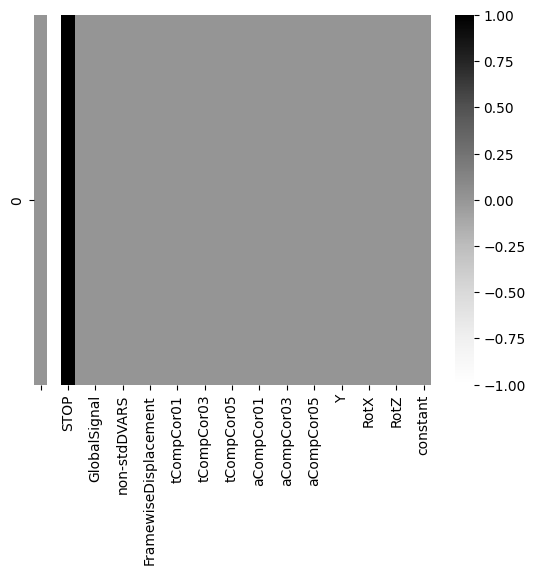

In [ ]:
# Plot contrast design matrix
temp_df = pd.DataFrame([contrasts_bw_conds['STOP_V_GO']], columns=dm_cols)


sns.heatmap(temp_df, cmap='Greys')


**Exercise:** Create the contrast maps for GO > STOP

In [ ]:
# Create contrast maps
for n_cont in range(len(contrasts_bw_conds)):
    cont_name = list(contrasts_bw_conds.keys())[n_cont]
    z_map = fmri_glm.compute_contrast(..., output_type='z_score')

    z_map.to_filename(os.path.join(outp_dir,'zmap_'+task+'_'+cont_name+'.nii.gz'))

plot_glass_brain(
    z_map,
    threshold=3,
    colorbar=True,
    plot_abs=False,
    display_mode="ortho", cmap='coolwarm'
)

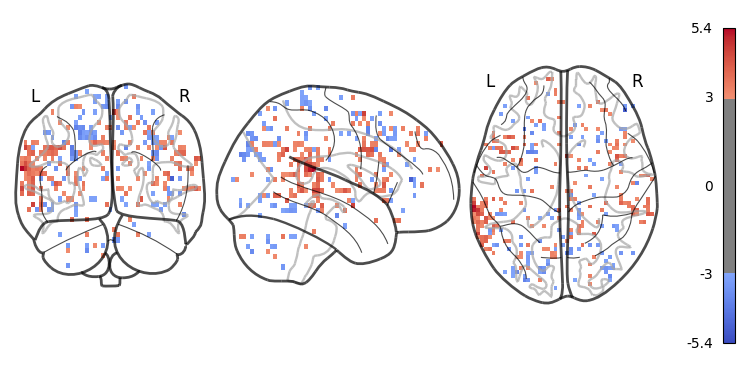

In [ ]:
# @title Click for solution
# Create contrast maps
for n_cont in range(len(contrasts_bw_conds)):
    cont_name = list(contrasts_bw_conds.keys())[n_cont]
    z_map = fmri_glm.compute_contrast(contrasts_bw_conds[cont_name], output_type='z_score')

    z_map.to_filename(os.path.join(outp_dir,'zmap_'+task+'_'+cont_name+'.nii.gz'))

plot_glass_brain(
    z_map,
    threshold=3,
    colorbar=True,
    plot_abs=False,
    display_mode="ortho", cmap='coolwarm'
)

**Exercise:** Use the [plot_stat_map](https://nilearn.github.io/stable/modules/generated/nilearn.plotting.plot_stat_map.html#nilearn.plotting.plot_stat_map) function to plot a sagital view of the whole brain, even 10 slices.

In [ ]:
plot_stat_map(...,
              cut_coords=range(-65,65, ...), display_mode=..., colorbar=True,
              cmap=..., symmetric_cbar=True, annotate=True)

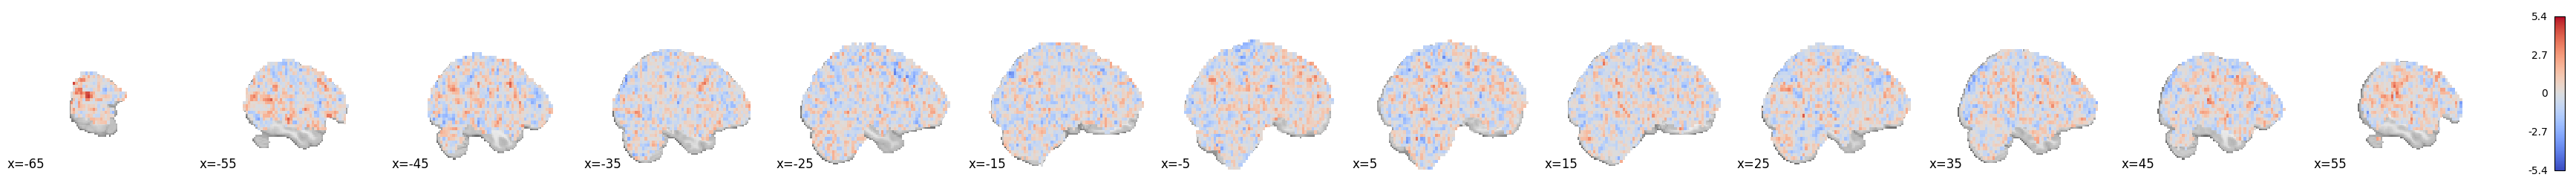

In [ ]:
# @title Click for solution
plot_stat_map(z_map,
              cut_coords=range(-65,65, 10), display_mode='x', colorbar=True,
              cmap='coolwarm', symmetric_cbar=True, annotate=True)

## Complete First Level Analysis For All Subjects

In [ ]:
for subj in subjs_list['participant_id'][1:5]:

  # Set output directory
  outp_dir = os.path.join(bids_dir, 'derivatives', task, subj)

  # Find all of the preprocessed functional runs
  func_runs = [f for f in glob.glob(bids_dir + '/derivatives/fmriprep/'+subj+'/func/'+subj+'_task-'+task+'*space-'+template+'_desc-preproc_bold.nii.gz', recursive=True)]
  func_runs.sort()
  print('Number of functional runs for '+subj+': '+str(len(func_runs)))

  if len(func_runs) == 0:
    continue


  # Grab subject's T1 as a mask to keep analysis in subject space
  #subj_mask = bids_dir+'derivatives/fmriprep/'+subj+'/anat/'+subj+'_space-'+template+'_label-GM_probseg_bin.nii.gz'

  # Find the task event files that are ready to become design matrices
  event_files = [f for f in glob.glob(bids_dir + '/derivatives/task_socialreward/data/SCN_'+subj[-3:]+'/'+subj+'_task-'+task+'_run-*_desc-events'+'.csv', recursive=True)]
  event_files.sort()

  # Set path to subject specific fmriprep output
  fmri_run_data_dir = bids_dir+'/derivatives/fmriprep/'+subj+'/func/'

  # Find confound regressors
  confounds = pd.read_csv(fmri_run_data_dir+subj+'_task-'+task+'_desc-confounds_regressors.tsv', sep='\t')

  # Replace NaN values with means for the respective variable
  confounds.fillna(confounds.mean(), inplace=True)

  fmri_glm = FirstLevelModel(t_r=tr,
                            #mask_img=subj_mask,
                            #slice_time_ref=0.5,  # Check to see how your data was preprocessed
                            noise_model='ar1',
                            standardize=False,
                            hrf_model='spm',
                            drift_model='polynomial')




  # Conduct the GLM using the functional data, event file, and the confounds
  fmri_glm = fmri_glm.fit(func_runs, events, confounds)

  # Specify the design matrix to pull conditions and contrasts later
  design_matrix = fmri_glm.design_matrices_[0]

  # Find the total number of conditions in the design matrix
  n_conds = len(design_matrix.columns)


  # Set contrasts for each condition, to make a beta map for each condition
  # This loop sets a column of 1s for each condition separately, so that
  # each condition can be examined separately
  contrasts = {}
  for cond in relv_conds:
    contrasts[cond] = np.zeros(n_conds)
    cond_idx = [design_matrix.columns.to_list().index(cond)]
    contrasts[cond][cond_idx] = 1


  # Make participant-specific directory for output if it doesn't exist
  if not os.path.exists(outp_dir):
    os.makedirs(outp_dir)

  # Create z-scored beta maps contrasts
  for n_cont in range(len(contrasts)):
    cont_name = list(contrasts.keys())[n_cont]
    z_map = fmri_glm.compute_contrast(contrasts[cont_name], output_type='z_score')

    z_map.to_filename(os.path.join(outp_dir,'zmap_'+task+'_'+cont_name+'.nii.gz'))



  # Create specific contrasts

  # Create a dictionary that will store the contrast arrays
  contrasts_bw_conds = {}

  dm_cols = list(design_matrix.columns)

  # Loop through and fill in 1s and 0s for contrasts
  for n in range(len(contrasts_df)):
      # Find the condition names to be contrasted
      cond_a = contrasts_df.loc[n,'cond_a']
      cond_b = contrasts_df.loc[n,'cond_b']

      # Create an array of zeros
      contrasts_bw_conds[cond_a+'_V_'+cond_b] = np.zeros(len(dm_cols))

      # Find the index of each condtion as defined before
      temp_idx_a = dm_cols.index(cond_a)
      temp_idx_b = dm_cols.index(cond_b)

      # Fill the exact condition index in the contrast array with a 1 or -1
      contrasts_bw_conds[cond_a+'_V_'+cond_b][temp_idx_a] = 1
      contrasts_bw_conds[cond_a+'_V_'+cond_b][temp_idx_b] = -1


  # Create contrast maps
  for n_cont in range(len(contrasts_bw_conds)):
      cont_name = list(contrasts_bw_conds.keys())[n_cont]
      z_map = fmri_glm.compute_contrast(contrasts_bw_conds[cont_name], output_type='z_score')

      z_map.to_filename(os.path.join(outp_dir,'zmap_'+task+'_'+cont_name+'.nii.gz'))

Number of functional runs for sub-10171: 1


/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: StopSignalDelay, SubjectResponseCorrectness, LadderTime, PresentedStimulusArrowDirection, SubjectResponseButtonCode, TrialOutcome, ReactionTime, onset_noTriggerAdjust, TimeCourse, TimeCourse_noTriggerAdjust, LadderMovement, LadderNumber, SubjectResponseButton
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


Number of functional runs for sub-10189: 1


/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: StopSignalDelay, SubjectResponseCorrectness, LadderTime, PresentedStimulusArrowDirection, SubjectResponseButtonCode, TrialOutcome, ReactionTime, onset_noTriggerAdjust, TimeCourse, TimeCourse_noTriggerAdjust, LadderMovement, LadderNumber, SubjectResponseButton
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


Number of functional runs for sub-10193: 0
Number of functional runs for sub-10206: 1


/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: StopSignalDelay, SubjectResponseCorrectness, LadderTime, PresentedStimulusArrowDirection, SubjectResponseButtonCode, TrialOutcome, ReactionTime, onset_noTriggerAdjust, TimeCourse, TimeCourse_noTriggerAdjust, LadderMovement, LadderNumber, SubjectResponseButton
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


# Second Level Analysis

Our second level analysis can be completed easily using some of the same methods from the first level analysis.

## Set Up

### Import packages

In [ ]:
import os
import glob
import pandas as pd
import numpy as np

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img, cluster_level_inference

### Set up directories

In [ ]:
# Set output directory
outp_dir = os.path.join(bids_dir, 'derivatives', task, 'group')

# Make participant-specific directory for output if it doesn't exist
if not os.path.exists(outp_dir):
  os.makedirs(outp_dir)

## Create Design Matrix

In the second level analysis, a second level design matrix is used where the rows of the design matrix are the participants, and the columns are the second level regressors of interest. In this case, we just want to see the group level results and whether across all participants, if there are regions of the brain that are sensitive to a given contrast or condition. This code will take us through a one sample t-test to examine whether neural responses at each voxel are greater than zero.

<Axes: label='conditions', ylabel='scan number'>

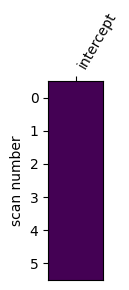

In [ ]:
# Create a design matrix using a list of subjects
design_matrix = make_second_level_design_matrix(subjs_list.loc[:5,'participant_id'])

plot_design_matrix(design_matrix)

## Conduct Second Level Analyses

In [ ]:
# Specify second level parameters

# Specify the conditions and contrasts we want to get group averages for
contrasts=['GO','STOP_V_GO']

# Set the multiple comparisons correction method to use
mc = 'fdr'

# Set the alpha for the multiple comparisons correction
alpha = 0.05

# Set the directory to look for the first level analysis output
data_dir = bids_dir+'/derivatives/stopsignal/'

# Loop through the contrasts
for contrast in contrasts:

    # Specify a list of the subjects to look for
    subjs_list_fl = list(subjs_list.loc[:5, 'participant_id'].copy())

    # Create a temporary list that will include only subjects that actually have
    # first level results
    temp_file_list = []
    for subj in subjs_list.loc[:5, 'participant_id']:

        # Find the first level results for a given subject
        temp_file = glob.glob(os.path.join(data_dir,subj,
                                           'zmap_'+task+'_'+contrast+'.nii.gz'))

        # Check that the first level results exist
        if len(temp_file) == 0:
            subjs_list_fl.remove(subj)  # Remove subject if no results found
            continue

        temp_file_list.append(temp_file[0])
    temp_file_list.sort()

    print('Calculating group '+contrast+' contrast for '+str(len(temp_file_list))+' subjects')

    # Create an updated second level design matrix with subjects that actually
    # have data
    design_matrix = make_second_level_design_matrix(subjs_list_fl)

    # Specify the second level model and parameters
    model = SecondLevelModel(#mask_img=mni_mask,
                             smoothing_fwhm=8.0)

    # Fit the model, using a list of subjects, and the design matrix
    model.fit(temp_file_list, design_matrix=design_matrix)

    # Compute the second level contrast
    contrast_stats = model.compute_contrast(output_type='all')

    # Pull the z-scored beta map
    z_map = contrast_stats['z_score']

    # Pull the effect size map
    e_map = contrast_stats['effect_size']

    # Save the maps
    z_map.to_filename(os.path.join(data_dir, 'group',
                               task+'_'+contrast+'_zmap.nii.gz'))
    e_map.to_filename(os.path.join(data_dir, 'group',
                               task+'_'+contrast+'_effect.nii.gz'))

    # Multiple Comparisons Correction
    z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

    z_map_thresh.to_filename(os.path.join(data_dir, 'group',
                                 task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))


Calculating group GO contrast for 4 subjects
Calculating group STOP_V_GO contrast for 5 subjects


## Visualize Results

In [ ]:
# @title Transparent plotting function
from matplotlib.gridspec import GridSpec

import matplotlib.pyplot as plt

from nilearn.plotting import plot_stat_map

def plot_transparent_threshold(filename, thresh=1, mc='fdr', mc_alpha=0.05, view='split', title=''):
    # Find stat map
    stat_filename = os.path.join(filename+'_effect.nii.gz')
    stat_filename_mc = os.path.join(filename+'_zmap_'+mc+'-'+str(mc_alpha)+'.nii.gz')



    if view == 'split':
        # Set figure specs
        fig = plt.figure(figsize=(15, 6))
        gs = GridSpec(4, 2)

        # Plot whole brain maps
        ax_img1 = plt.subplot(gs[0, :])
        ax_img2 = plt.subplot(gs[1, :])

        hemi_lh = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img1,
                                cut_coords=range(-65,0, 10), display_mode='x', colorbar=True,
                                cmap='coolwarm', symmetric_cbar=True, title='Left Hemisphere',
                                annotate=False)
        hemi_rh = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img2,
                                cut_coords=range(66,5, -10), display_mode='x', colorbar=True,
                                cmap='coolwarm', symmetric_cbar=True, title='Right Hemisphere',
                                annotate=False)
        hemi_lh.add_contours(stat_filename_mc, levels=[-mc_alpha,mc_alpha], colors=['blue','red'],
                          alpha=1, linewidths=1)
        hemi_rh.add_contours(stat_filename_mc, levels=[-mc_alpha,mc_alpha], colors=['blue','red'],
                          alpha=1, linewidths=1)


        # Plot ventral striatum ROI
        ax_img3 = plt.subplot(gs[2:, 1])

        roi_map = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img3,
                                cut_coords=[8], display_mode='y', colorbar=False,
                                cmap='coolwarm', symmetric_cbar=True,
                                annotate=True)
        roi_map.add_contours(stat_filename_mc, levels=[-mc_alpha,mc_alpha], colors=['blue','red'],
                          alpha=1, linewidths=1)



The following plot is inspired by the [transparent results visualization method](https://www.sciencedirect.com/science/article/pii/S1053811923002896) put forward by the AFNI group. Clusters which have survived multiple comparisons correction are outlined in bold red or blue lines (in this analysis, there are none). The rest of the map includes the effect size map, with more bold colors indicating a greater effect size.

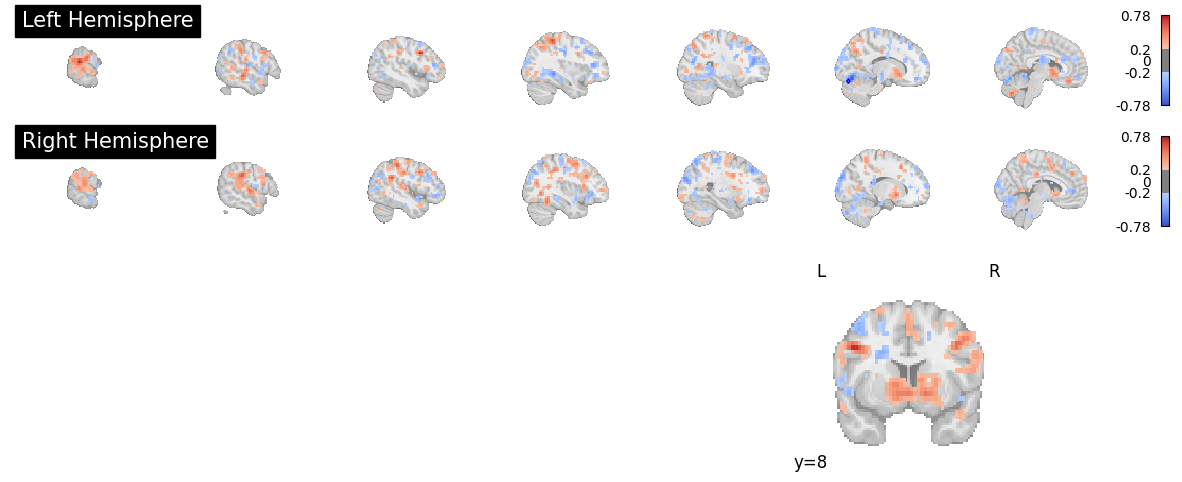

In [ ]:
# Set path of the analysis to plot
# Dont include the file suffixes ("_effect", "_zmap") and extensions (.nii.gz)
filename = data_dir+'/group/'+'stopsignal_STOP_V_GO'

plot_transparent_threshold(filename, thresh=.2, mc_alpha=0.05)

The nilearn plotting functions are again built off of well-established python packages. This allows us to use these other python methods to play around with how we plot our data, color the maps, focus on specific brain regions, and combine figures using subplots. In the above figure, I have slices showing the entire left and right hemispheres, and then a coronal slice highlighting the striatum.